## 1. CNN

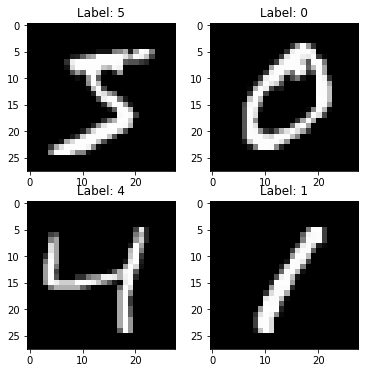

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**Problem a** Implement CNN which has 2 conv layers, and max-pool, use relu activation. The last layer is fully connected. Find parameters so that output of the last conv layer is 4 x 4 x 16. 

We use nn.Sequential, read the documentation.

You need to get the training error rate below 1.5%.

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        filters = 16
        kernel_size = (5, 5)
        self.features = nn.Sequential(
            nn.Conv2d(1, 2 * filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(2 * filters, filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        feature_map = self.features.forward(x)
        out = self.classifier.forward(feature_map.view(-1, 4 * 4 * 16))
        return F.log_softmax(out, dim=-1)

Count the number of parameters

In [3]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 16218


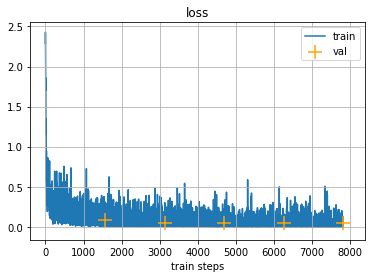

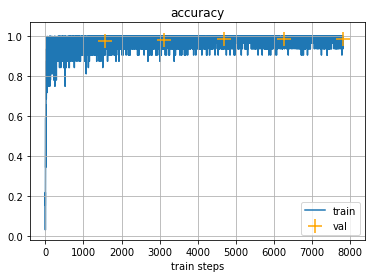

Epoch 4 error = 1.40%
Final error: 1.40%
Wall time: 6min 36s


In [4]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

**Problem b:** 
* Why we use CNN for images rather than fully connected layers? 

        --> We use CNN for images rather than fully connected layers because of its high accuracy (clasification quality) i.e. less error rate.

* CNN have smalle number of parameters. Why it takes longer to train those? 

        --> CNN can do a lot with very few parameters. i.e. they share those parameters in their network i.e. using it multiple times. Hence, the computational time is more for CNN even with very less parameters.

# 2. RNN
We will analyze names dataset and will detect the country of origin for a given name. Our RNN will take a name and process it character-by-character. First we download the files and reshape the data.

In [5]:
# On a windows machine, you need to download and unzip by yourself
! wget -nc https://download.pytorch.org/tutorial/data.zip
! unzip -n ./data.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('Desktop/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['Desktop/data/names\\Arabic.txt', 'Desktop/data/names\\Chinese.txt', 'Desktop/data/names\\Czech.txt', 'Desktop/data/names\\Dutch.txt', 'Desktop/data/names\\English.txt', 'Desktop/data/names\\French.txt', 'Desktop/data/names\\German.txt', 'Desktop/data/names\\Greek.txt', 'Desktop/data/names\\Irish.txt', 'Desktop/data/names\\Italian.txt', 'Desktop/data/names\\Japanese.txt', 'Desktop/data/names\\Korean.txt', 'Desktop/data/names\\Polish.txt', 'Desktop/data/names\\Portuguese.txt', 'Desktop/data/names\\Russian.txt', 'Desktop/data/names\\Scottish.txt', 'Desktop/data/names\\Spanish.txt', 'Desktop/data/names\\Vietnamese.txt']
Slusarski


In [7]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('Desktop/data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

Define a few convenience functions to convert words to tensors

**Problem a**: define the last function for converting word to a tensor

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i] = letterToTensor(letter)
    return tensor
    
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Problem b** Define one-layer RNN

In [9]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.input_layer = nn.Linear(input_size, hidden_size)

    def forward(self, inp, hidden):
        inp = inp
        hidden = hidden
        hidden = self.hidden_layer.forward(hidden) + self.input_layer.forward(inp)
        hidden = torch.tanh(hidden)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

We predict using liner classifier (the last layer)

In [10]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Let's check if everything works correctly: outputs should be log-probabilities

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8252, -2.7337, -3.0112, -2.9255, -2.8879, -2.9556, -2.9205, -3.0078,
         -2.9447, -2.8261, -2.9288, -2.7569, -2.8631, -2.8774, -2.8768, -2.8794,
         -2.7568, -3.1316]], grad_fn=<LogSoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)
tensor([[-2.8252, -2.7337, -3.0112, -2.9255, -2.8879, -2.9556, -2.9205, -3.0078,
         -2.9447, -2.8261, -2.9288, -2.7569, -2.8631, -2.8774, -2.8768, -2.8794,
         -2.7568, -3.1316]], grad_fn=<LogSoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


For simplicity, we will use mini-batch SGD. Below are several helper functions to set it up

In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = names\Dutch / line = Alst
category = names\Irish / line = Dubhan
category = names\Greek / line = Close
category = names\Dutch / line = Sniders
category = names\Czech / line = Sponer
category = names\Chinese / line = Chao
category = names\Czech / line = Kreutschmer
category = names\Greek / line = Metrofanis
category = names\Arabic / line = Nader
category = names\German / line = Vo


**Problem c** Implement function train. If you did everything correctly the train accuracy should be at least  70%.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:18<00:00, 251.64it/s]


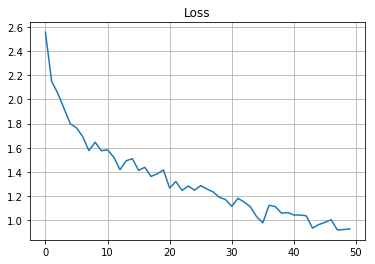

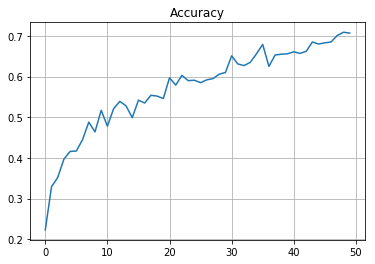

In [13]:
from tqdm import trange

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    # <your code here>
    # use rnncell and classifier
    # <end>
    for letter_tensor in line_tensor:
        hidden = rnncell.forward(letter_tensor, hidden)
    output = classifier.forward(hidden)
    
    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in trange(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Problem 2. Vanishing Gradients

We will use MNIST dataset, but analyze it using fully-connected networks. The goal is not to find the best architecture. We are interested in learning process for deep networks.

In [14]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

We will define a flexible network init funciton that allows to change number of layers. Also you need to save gradients at each layer, so we can analyze those. 

**Problem a** complete the code below

In [15]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l_0 = nn.Linear(X_train.shape[1], hidden_size)
        a_0 = self.activation()
        self.weights = [l_0.weight]
        self.layers = [l_0, a_0]
        
        for i in range(1, n_layers):
            if i != n_layers - 1:
                l_i = nn.Linear(hidden_size, hidden_size)
            else:
                l_i = nn.Linear(hidden_size, 10)
            self.layers.append(l_i)
            self.weights.append(l_i.weight)
            if i != n_layers - 1:
                a_i = self.activation()
                self.layers.append(a_i)
        #print(self.layers)
        self.seq = nn.Sequential(*self.layers)
        
        print(self.seq)
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        out = self.seq.forward(x)
        
        return F.log_softmax(out, dim=-1)

Modify our train function so that it plots gradients

In [16]:
import scipy.sparse.linalg

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        pred = torch.max(output, 1)[1].numpy()
        #print(pred)
        #print(y_batch)
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # display all metrics
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')    

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Problem b**
* Train network with more than 10 layers with sigmoid activation function. Investigate how depth affects the quality of the learning process and gradient changes on the layers that are far from the output. 
* Change activation to ReLU and see what happens

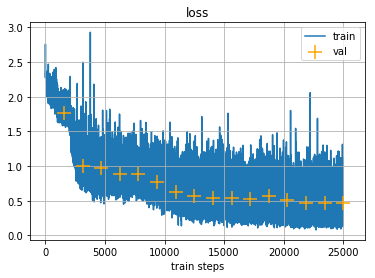

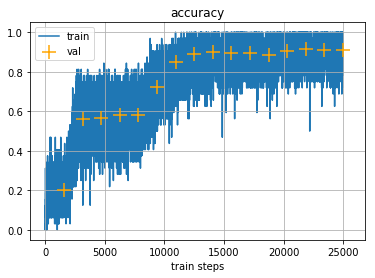

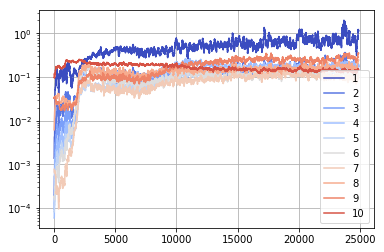

In [17]:
dense_net_sigm = DeepDenseNet(n_layers=10, hidden_size=16, activation=nn.Sigmoid)
params=dense_net_sigm.weights
opt = torch.optim.RMSprop(params, lr=0.01)

train_grad(dense_net_sigm, opt, 16)

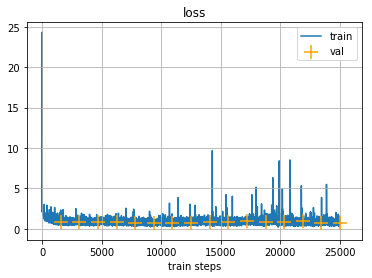

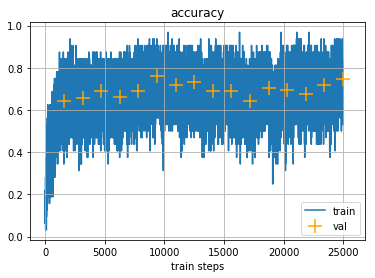

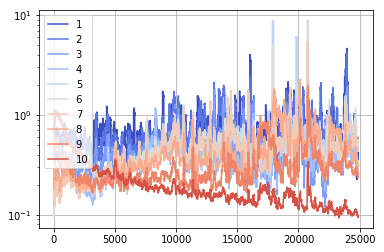

In [18]:
dense_net_relu = DeepDenseNet(n_layers=10, hidden_size=16, activation=nn.ReLU)
params=dense_net_relu.weights
opt = torch.optim.RMSprop(params, lr=0.01)

train_grad(dense_net_relu, opt, 16)

Now we add skip-connections (like in ResNet) instead of changing sigmoid to  relu and see what happens. 

We cannot use nn.Sequential anymore, we need to apply our layers one-by-one. However, still add those to a nn.Sequential, otherwise torch won't be able to optimize.

**Problem c** complete the code below

In [19]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)
            
        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        
        cur = self.layers[0].forward(x)
        for layer in self.layers[1:]:
            cur = layer(cur) + cur
        
        return F.log_softmax(cur, dim=-1)

Let's make sure that this architecture can be trained even with large number of layers

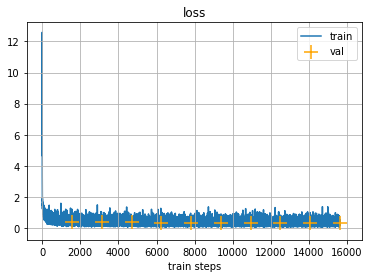

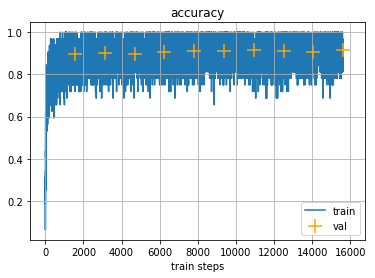

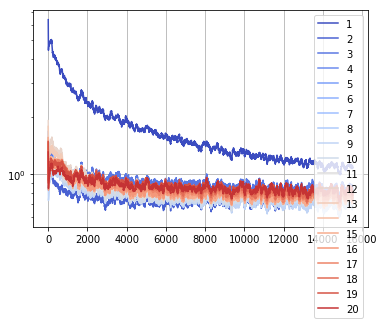

In [20]:
model = DeepDenseResNet(n_layers=20, hidden_size=10, activation=nn.Sigmoid)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)